In [1]:
# a brief departure from the other notebooks, this exists to test a trajectory analysis tool I used in early graduate school
# there is some concern of package incompatibility, so I will try and sort that out here. As such this notebook will be much more of a 
# train of thought document than the others in this repo
# pCreode test data can be found here:https://github.com/KenLauLab/pCreode/blob/master/data/Myeloid_Raw_Normalized_Transformed.h5ad

In [3]:
# install necessary packages
# pip install pcreode

  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://g

In [4]:
# immediately the first issue seems clear, pcreode calls for sklearn when that package name has been deprecated for scikit-learn, this means
# installation using pip is out. Instead clone from github, update requirements.txt, setup.py and try again

# Note: to install from github do the following in a terminal
# git clone git://github.com/KenLauLab/pCreode
# cd pCreode
# sudo pip install .

In [1]:
# now that pCreode installed, import packages 
import scanpy as sc # import scanpy
import pandas as pd # pandas 
import numpy as np # import numpy
import pcreode # import pcreode
import matplotlib.pylab as plt # import matplotlib 
from sklearn.cluster import KMeans # import the KMeans algorithm from scikit-learn

In [2]:
# great, the import worked, so now we will follow along with the tutorial notebook to make sure the installed package works
sc.set_figure_params(dpi=80) #set figure display size

In [5]:
# as a side effect of installing the package through github, the test data set is installed as well
myeloid_adata = sc.read_h5ad("../pCreode/data/Myeloid_Raw_Normalized_Transformed.h5ad")
myeloid_adata

AnnData object with n_obs × n_vars = 4423 × 14955

/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:357: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:357: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/pandas/core/util/hashing.py:357: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


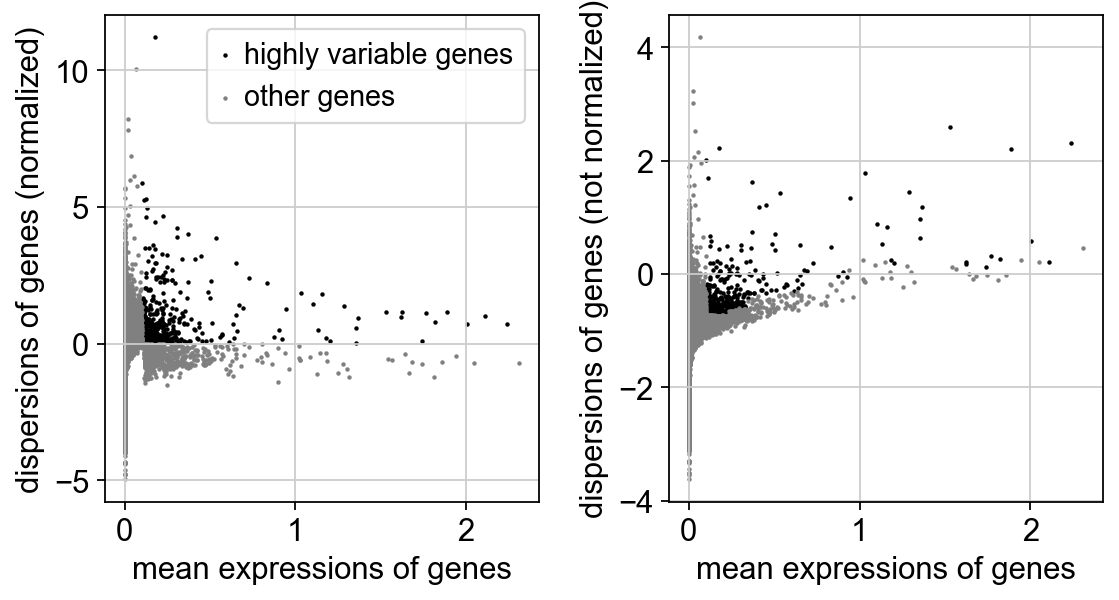

In [13]:
# note for those following the pCreode tutorial, you need to remove the max value params, changes to scanpy now cause max_mean=None to 
# error out when supplying min_min values to do a Big !< Small error
sc.pp.highly_variable_genes(myeloid_adata, min_mean=.1, min_disp=0)
sc.pl.highly_variable_genes(myeloid_adata)

In [14]:
# the hvg selection process selected 558 of the original ~15k
myeloid_adata.var.index[np.where(myeloid_adata.var['highly_variable'])[0]]

Index(['0610012G03RIK', '0910001L09RIK', 'MIR1892', 'MCMBP', 'RPL36AL',
       '1110038B12RIK', '1190002H23RIK', '1500011K16RIK', '1500012F01RIK',
       '1810009A15RIK',
       ...
       'XPNPEP1', 'XRN2', 'YWHAQ', 'ZCRB1', 'ZFP106', 'ZFPM1', 'ZYX', 'WDR43',
       'TLN1', 'RP9'],
      dtype='object', name='index', length=558)

/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


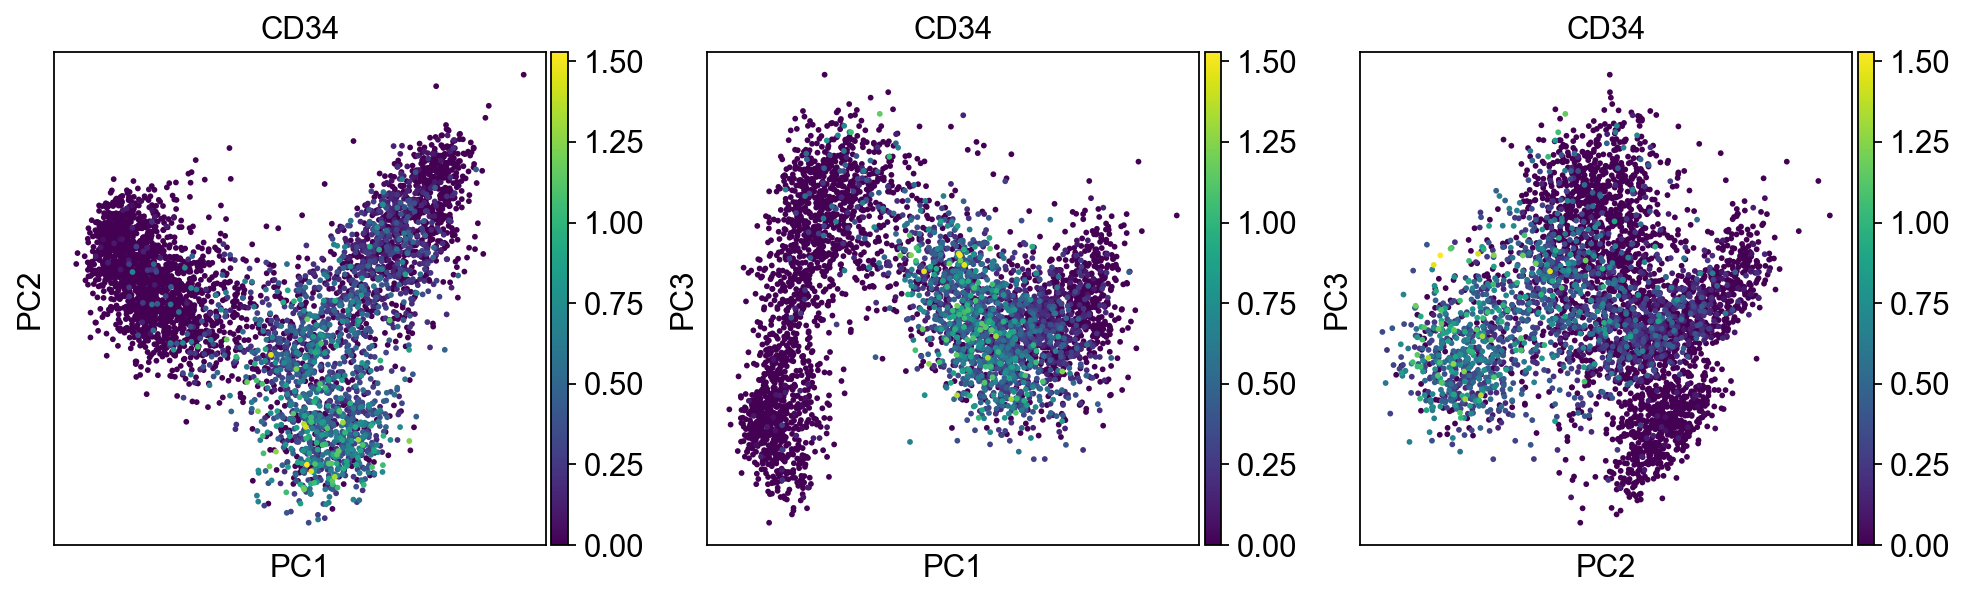

In [15]:
# in classic single cell fashion, now we plot before and after selection
sc.pp.pca(myeloid_adata, n_comps = 20, use_highly_variable=False)
sc.pl.pca(myeloid_adata, components=['1,2','1,3','2,3'], color='CD34') 

/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


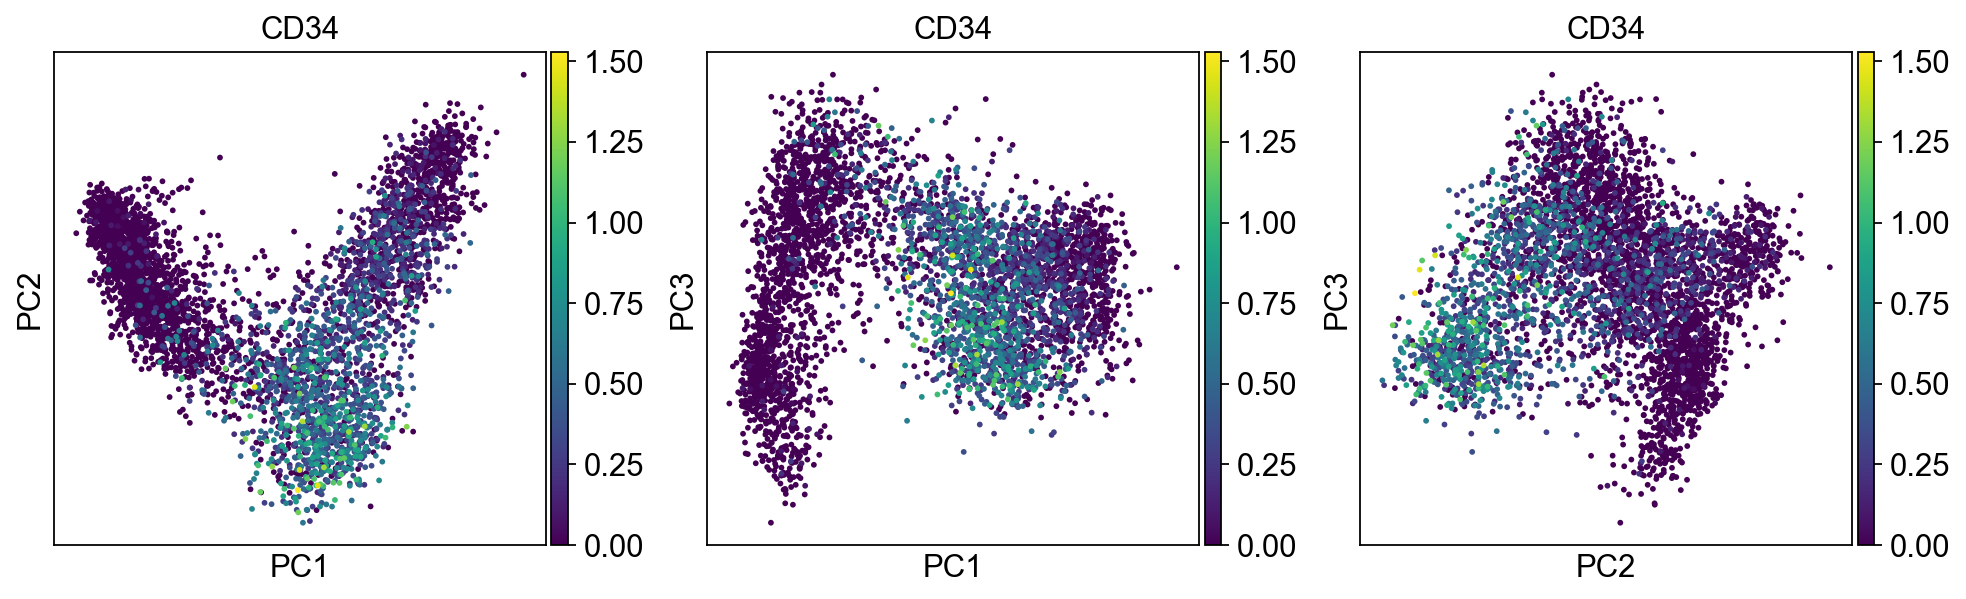

In [16]:
sc.pp.pca(myeloid_adata, n_comps = 20, use_highly_variable=True)
sc.pl.pca(myeloid_adata, components=['1,2','1,3','2,3'], color='CD34') 

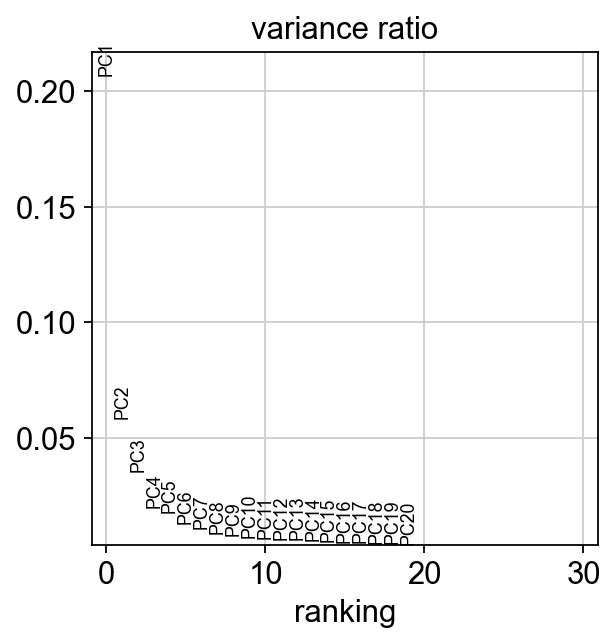

In [17]:
# while cd34 (HS/PC marker) clustering is consistent between both plots, we have acheived high quality clustering using 4% of the original
# dataset and extracted the clearest biological signals
# now plot PCs by varianec ratio to sort out a PC cutoff for clustering
sc.pl.pca_variance_ratio(myeloid_adata)

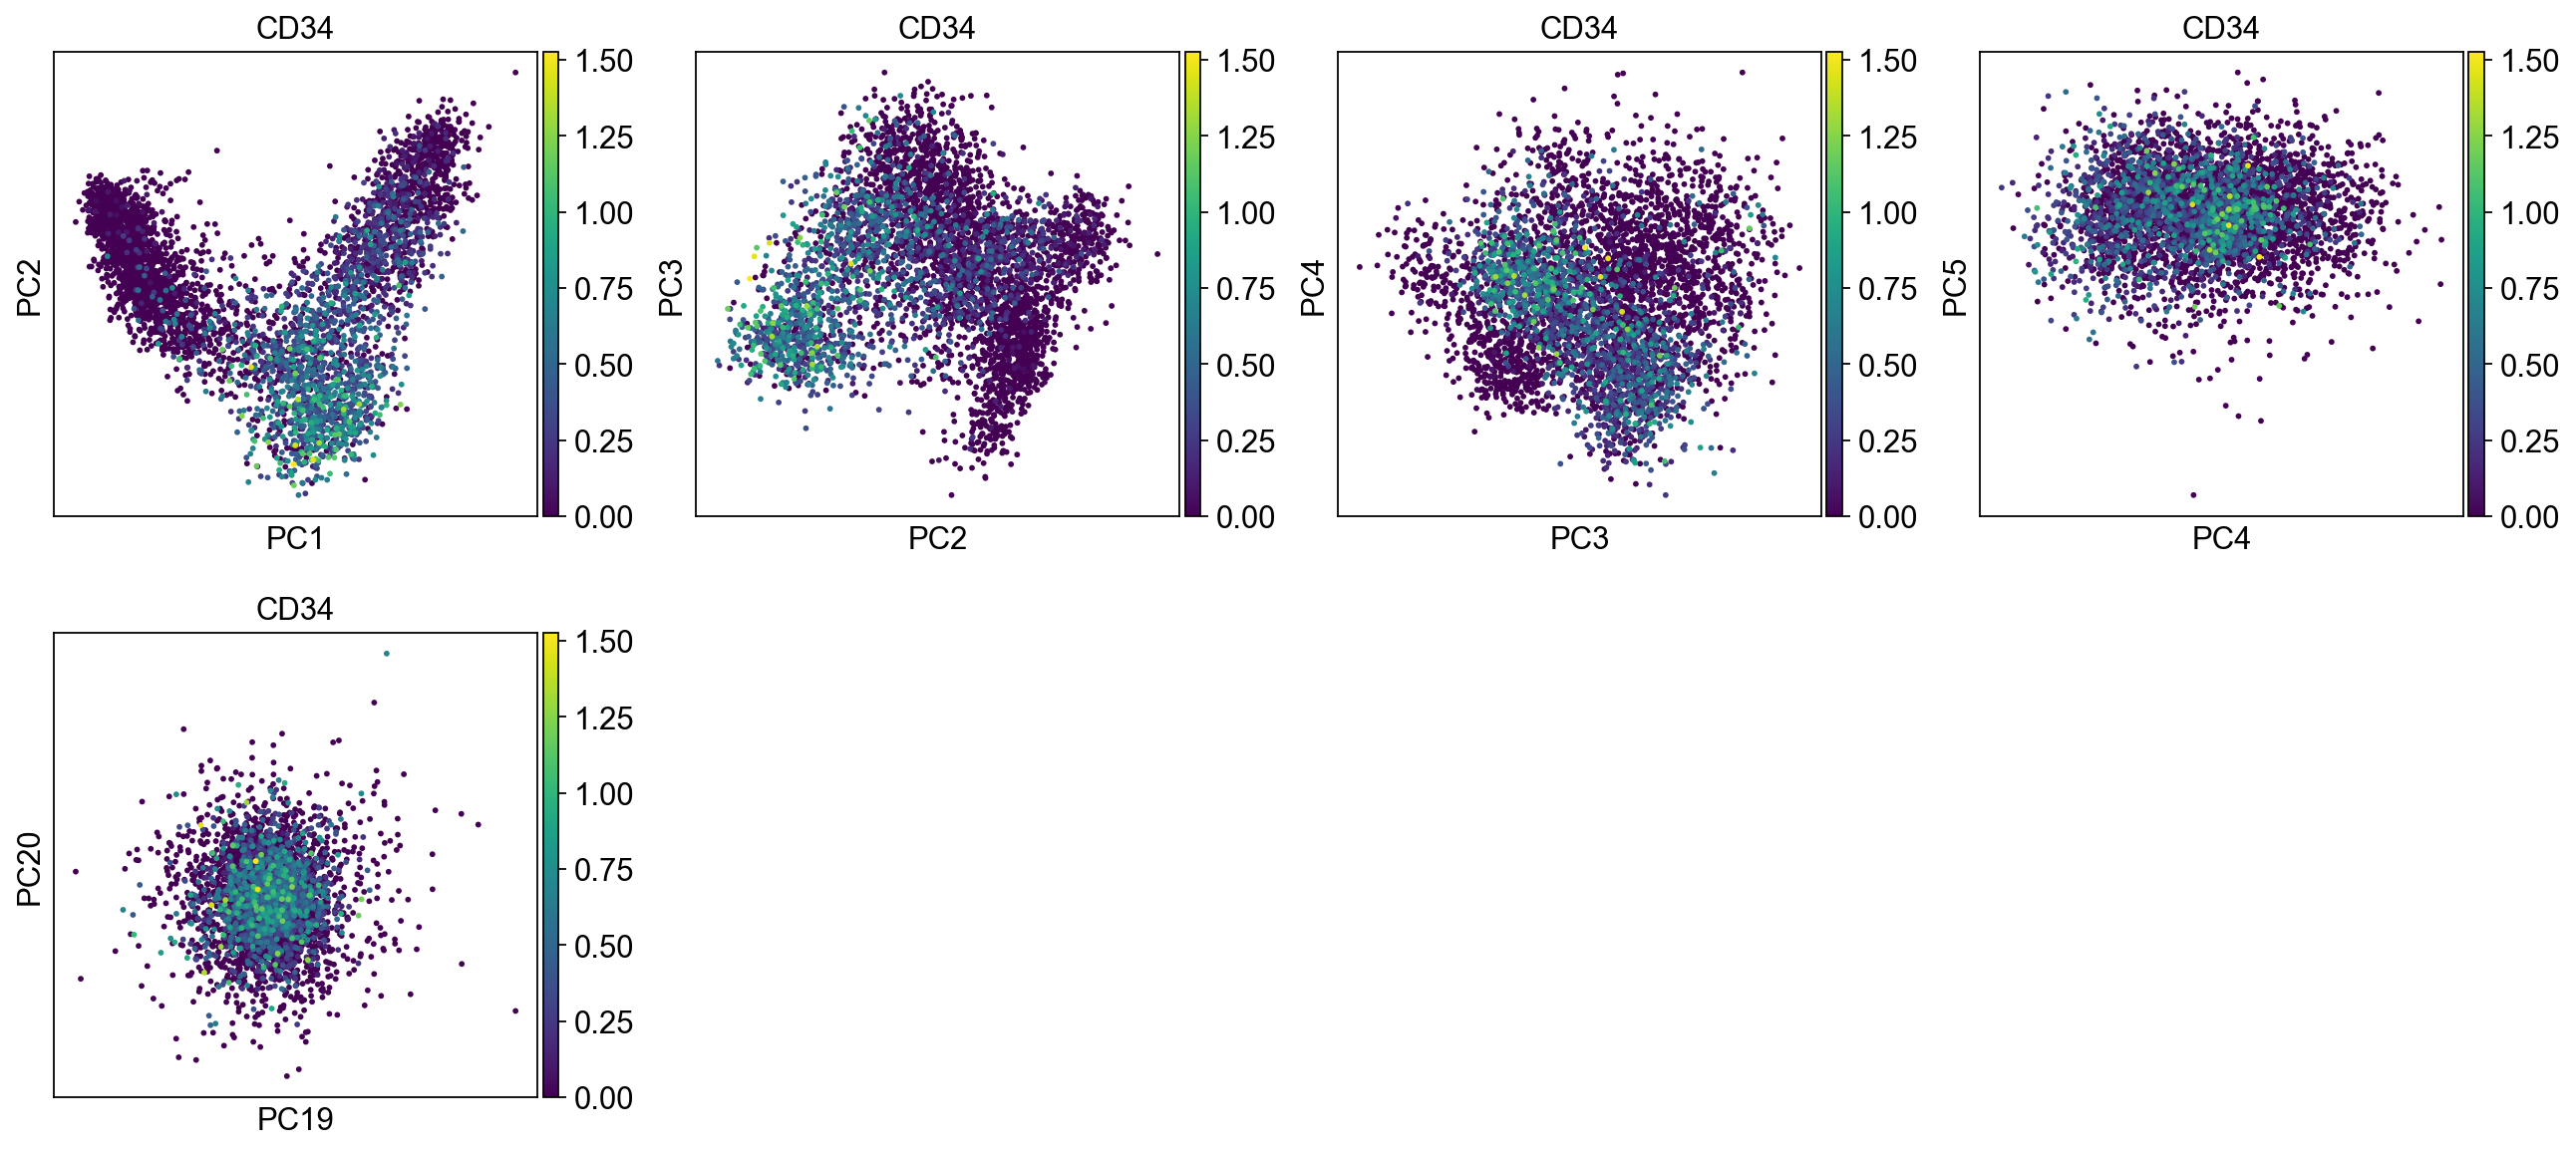

In [18]:
# note: the majority of variance is found in PCs 1-10. another way to visualize this is 
# plotting data using descending PCs, looking for decreases in dispersion
sc.pl.pca(myeloid_adata,components=['1,2','2,3','3,4','4,5','19,20'],color='CD34') 


In [19]:
# we see little structure when using pc4 or 5, suggesting that there is little gain in using more than 3 pcs for further analysis
pca_reduced_data = myeloid_adata.obsm['X_pca'][:,:3]

In [22]:
# now pca_reduced_data tells us the coordinates of each cell in 3d PC space. From here we move from preprocessing to density calcs
### Density Calculation
dens = pcreode.Density(pca_reduced_data)

best guess starting radius = 0.7190215587615967


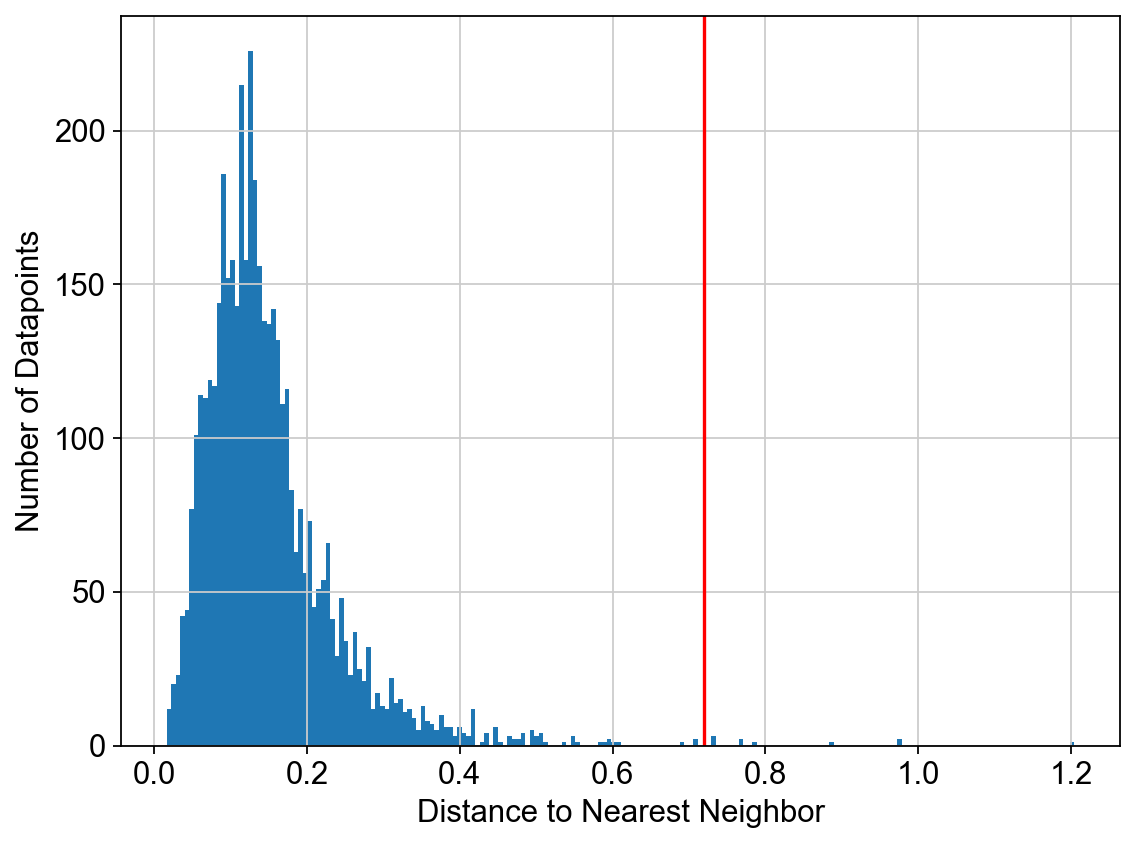

In [23]:
# Note: our first test of a pCreode class was successful! The issues may be soldev.
# a radius of inclusion needs to be established when calculating density. This is a manual process that is started by evaluating the 
# distances between nearest neighbors
best_guess = dens.nearest_neighbor_hist()

calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


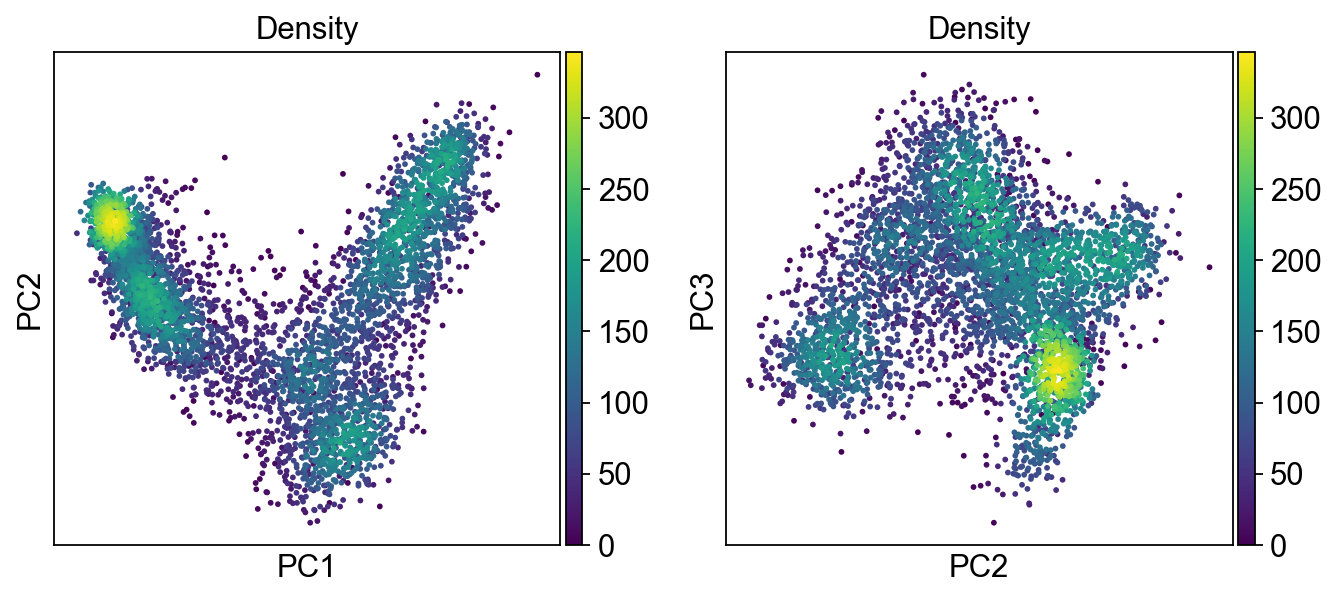

In [25]:
myeloid_adata.obs['Density'] = dens.get_density( radius=best_guess)
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components


calculating densities for datapoints: 0 -> 4422
****Always check density overlay for radius fit****


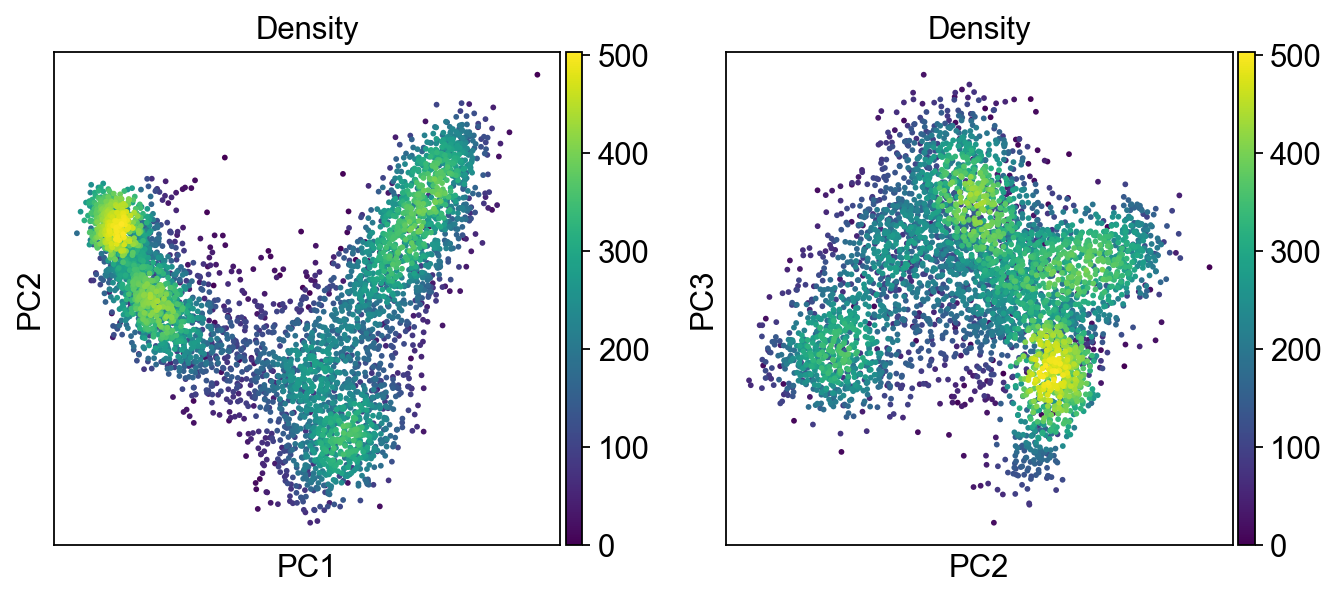

In [26]:
# this density is a little low (limited high density areas) increase the radius to see if that fixes it 
myeloid_adata.obs['Density'] = dens.get_density( radius=1)
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  #overlay each cell's Density value onto a three principal components


In [27]:
# great, we see a number of density hot spots, but the data aren't washed out. will proceed with radius = 1
# now we down-sample using a noise threshold and a target density (density target is used to control computational load)
noise = 8 # noise cutoff based on density value
target = 20 # target downsampling proportion

In [28]:
downed, downed_ind = pcreode.Down_Sample( pca_reduced_data, myeloid_adata.obs['Density'], noise, target)

Number of data points in downsample = 2490


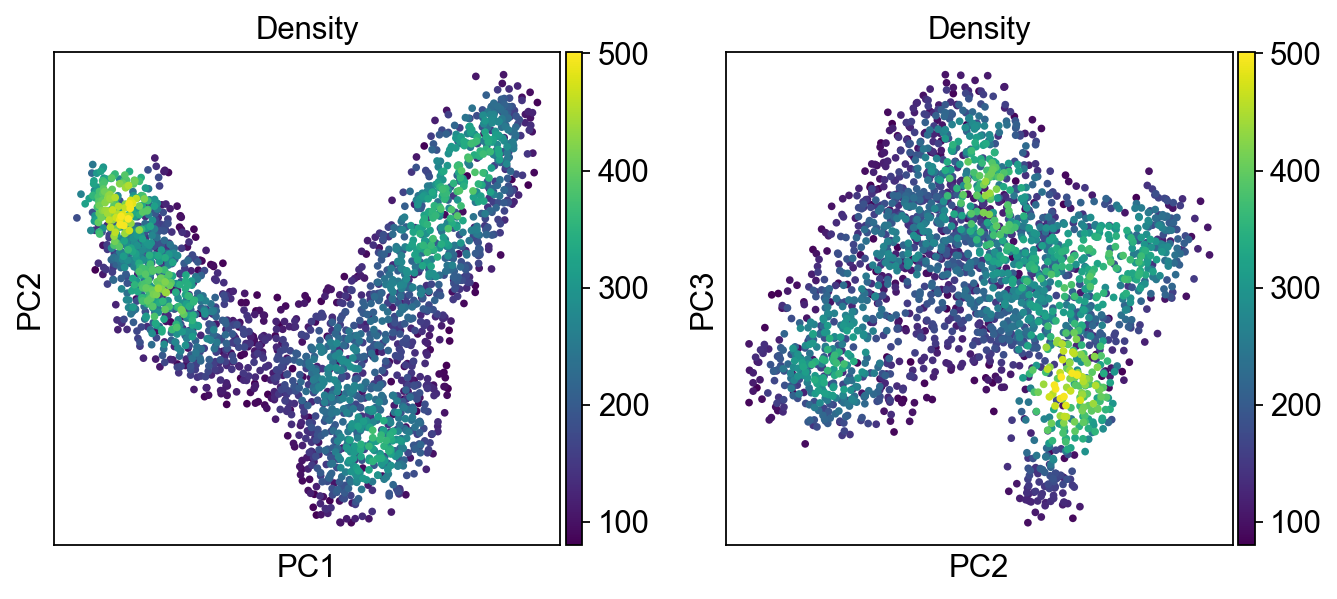

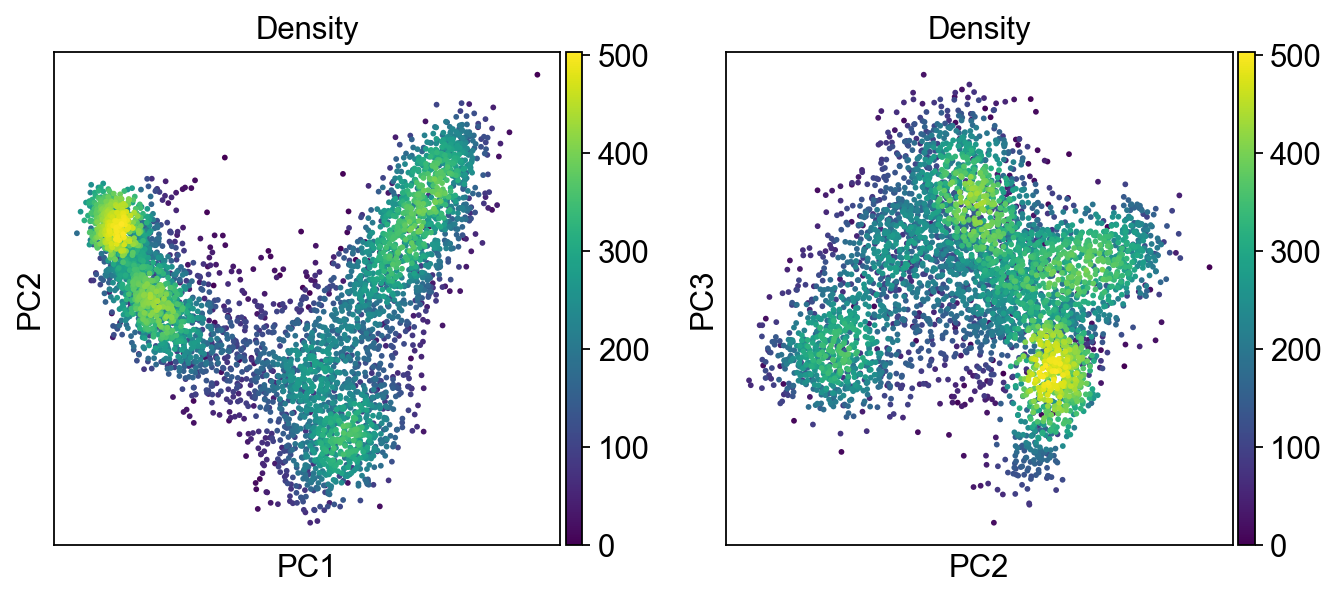

In [29]:
# now we compare down sampled PCA plots to the original 
sc.pl.pca(myeloid_adata[downed_ind],components=['1,2','2,3'],color = 'Density')  # density downsampled
sc.pl.pca(myeloid_adata,components=['1,2','2,3'],color = 'Density')  # no downsampled


In [30]:
# the removal of outliers (singleton genes outside of the main cluster) suggests that our noise threshold was appropriate
# beware: a rare cell looks alot like an outlier to PCA, so the noise threshold needs to be balanced so that real data isn't removed

In [32]:
# now we generate pCreode graphs
file_path = "pCreode_out/" 

In [33]:
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise, 
                                      target=target, file_path=file_path, num_runs=10)

Performing 10 independent runs, may take some time
Number of data points in downsample = 2496


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [35]:
# cool, we have found another error! unfortunately we will now need to get a bit more into the weeds to change the variable declaration.
# then we will need to re-install the package. First save the adata object so that we don't need to redo the processing
myeloid_adata.write('myeloid_adata.h5ad')

In [36]:
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise, 
                                      target=target, file_path=file_path, num_runs=10)

Performing 10 independent runs, may take some time
Number of data points in downsample = 2503


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
myeloid_adata = sc.read_h5ad("myeloid_adata.h5ad")
myeloid_adata

AnnData object with n_obs × n_vars = 4423 × 14955
    obs: 'Density'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [7]:
pca_reduced_data = myeloid_adata.obsm['X_pca'][:,:3]
noise = 8
target = 20
file_path = "pCreode_out/" 
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise, 
                                      target=target, file_path=file_path, num_runs=10)

Performing 10 independent runs, may take some time
Number of data points in downsample = 2516
Constructing density kNN
finding endstates


/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Number of endstates found -> 6
hierarchical placing


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [4]:
# cool, so it wasn't just the floats, it was the ints too. At least we have failed somewhere else now and know what to do. Back shortly

In [5]:
pca_reduced_data = myeloid_adata.obsm['X_pca'][:,:3]
noise = 8
target = 20
file_path = "pCreode_out/" 
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=np.array(myeloid_adata.obs['Density']), noise=noise, 
                                      target=target, file_path=file_path, num_runs=10)

Performing 10 independent runs, may take some time
Number of data points in downsample = 2521
Constructing density kNN
finding endstates


/opt/miniconda3/envs/test_jupyter_env/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 1
Number of data points in downsample = 2474
Constructing density kNN
finding endstates
Number of endstates found -> 4
hierarchical placing
consensus aligning
saving files for run_num 2
Number of data points in downsample = 2484
Constructing density kNN
finding endstates
Number of endstates found -> 4
hierarchical placing
consensus aligning
saving files for run_num 3
Number of data points in downsample = 2443
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 4
Number of data points in downsample = 2513
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving files for run_num 5
Number of data points in downsample = 2507
Constructing density kNN
finding endstates
Number of endstates found -> 6
hierarchical placing
consensus aligning
saving fi

In [7]:
# success! (don't look at the runtime warnings) now we can score the generated graphs to find the most representative graph
# this is an unsupervised approach to determing which graph the pCreode algorith 'thinks' is the best representative of the data
graph_ranks = pcreode.pCreode_Scoring(data=pca_reduced_data, file_path=file_path, num_graphs=10)

scoring graph 1
scoring graph 2
scoring graph 3
scoring graph 4
scoring graph 5
scoring graph 6
scoring graph 7
scoring graph 8
scoring graph 9
Most representative graph IDs from first to worst [2 1 4 8 6 7 5 9 3 0]


In [9]:
# now we can plot our most representative graph
gid = graph_ranks[0]
analysis = pcreode.Analysis(file_path=file_path, graph_id=gid, data=pca_reduced_data, 
                            density=np.array(myeloid_adata.obs['Density']), noise=noise)

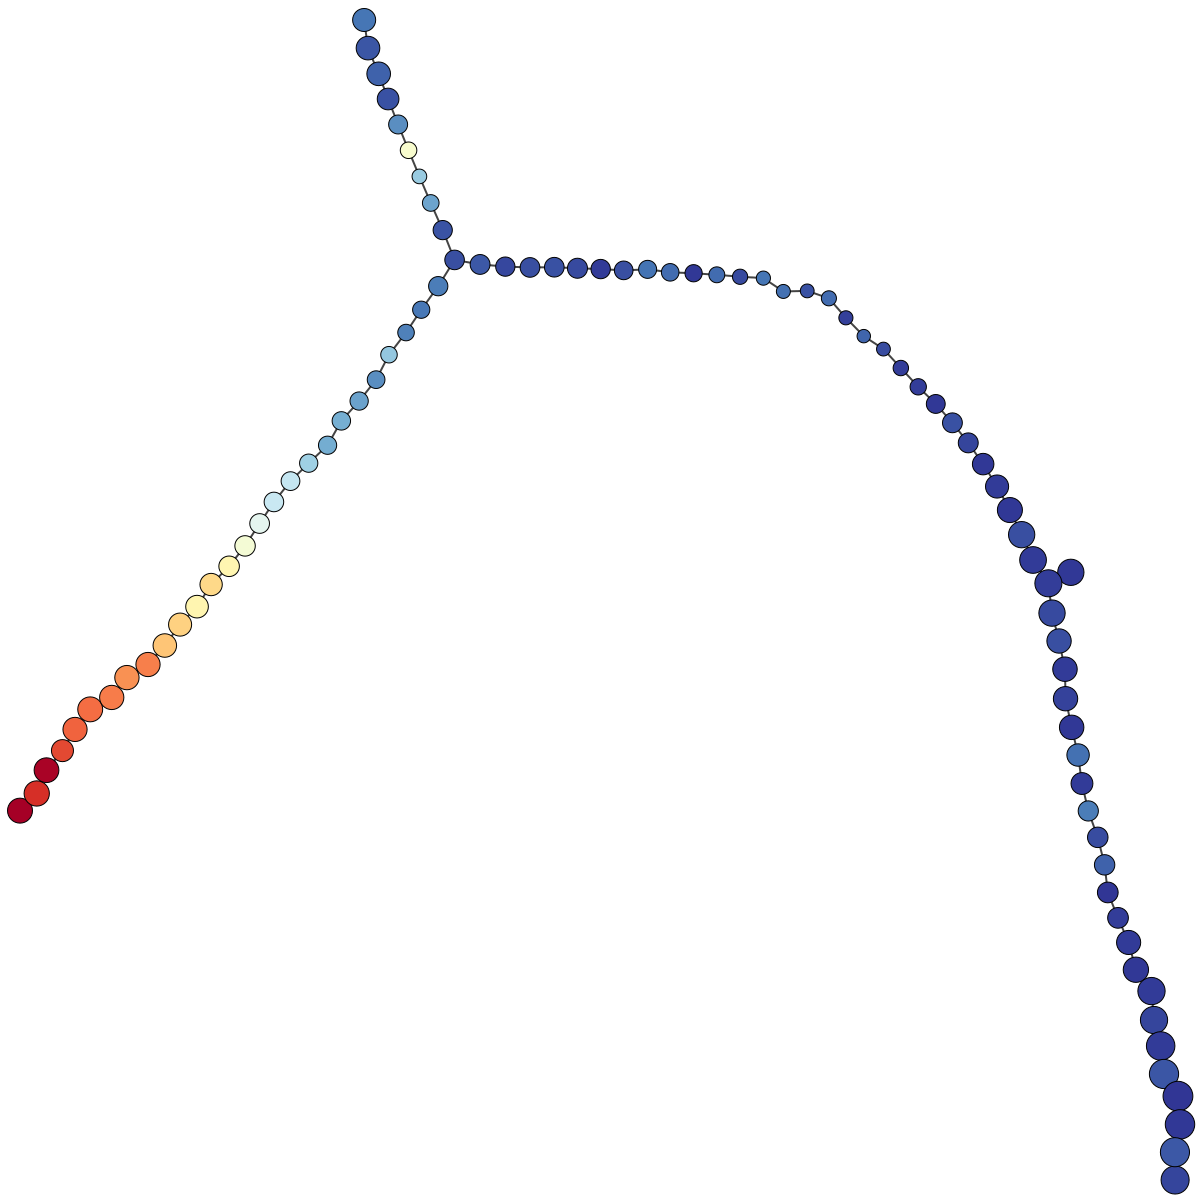

In [10]:
# set a random seed to control the output graph
seed=5656565656565656565656
analysis.plot_save_graph( seed=seed, overlay=pd.Series(myeloid_adata.obs_vector('ELANE')), file_out='ELANE', upper_range=1.25)

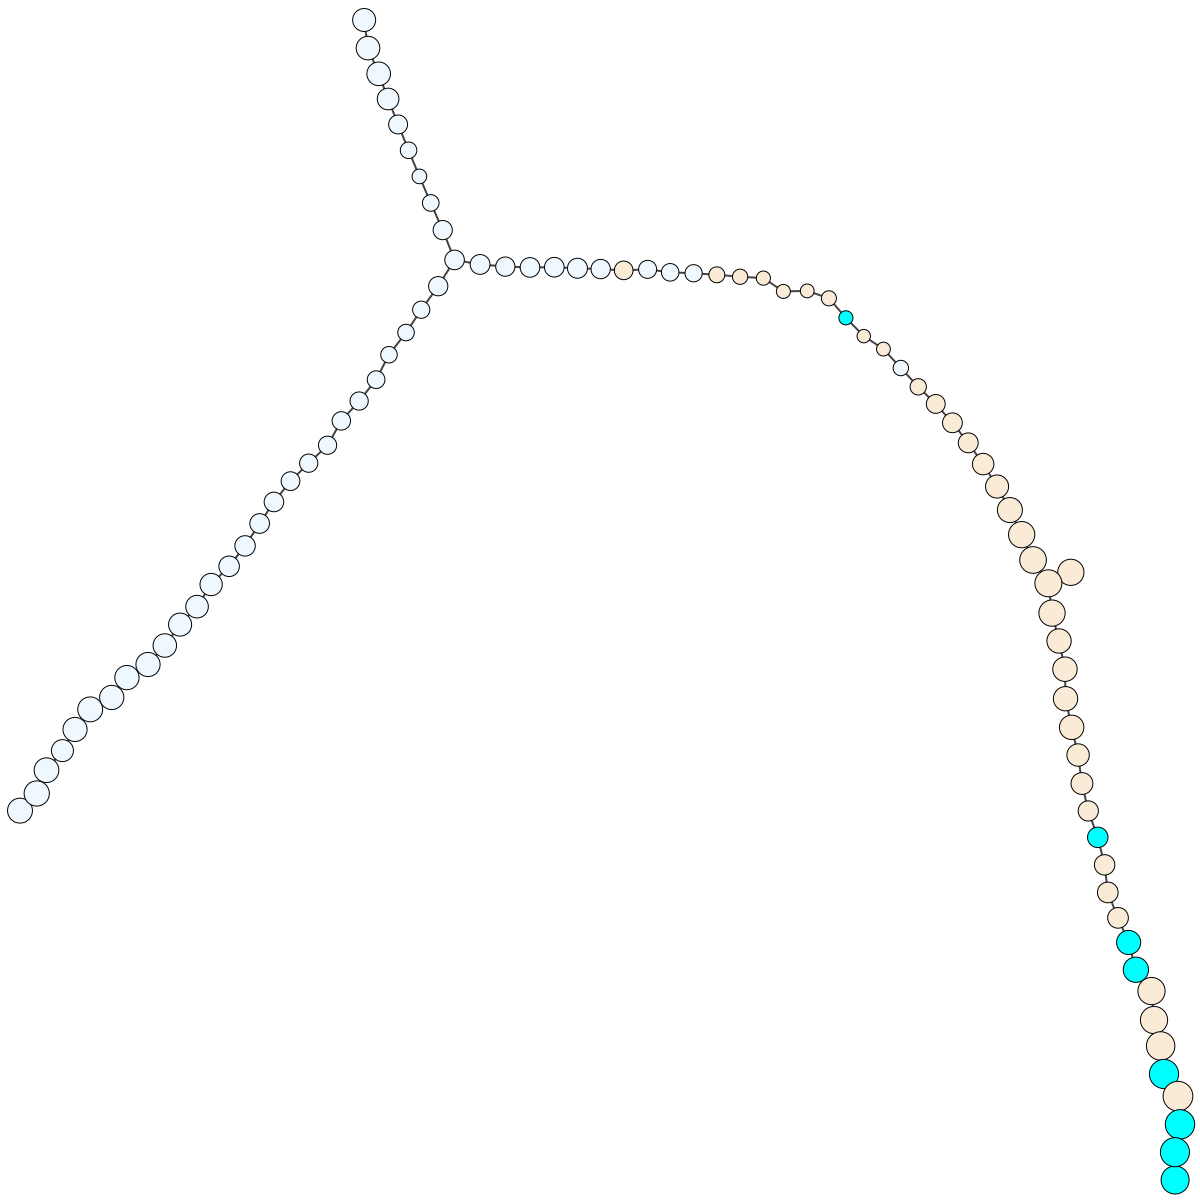

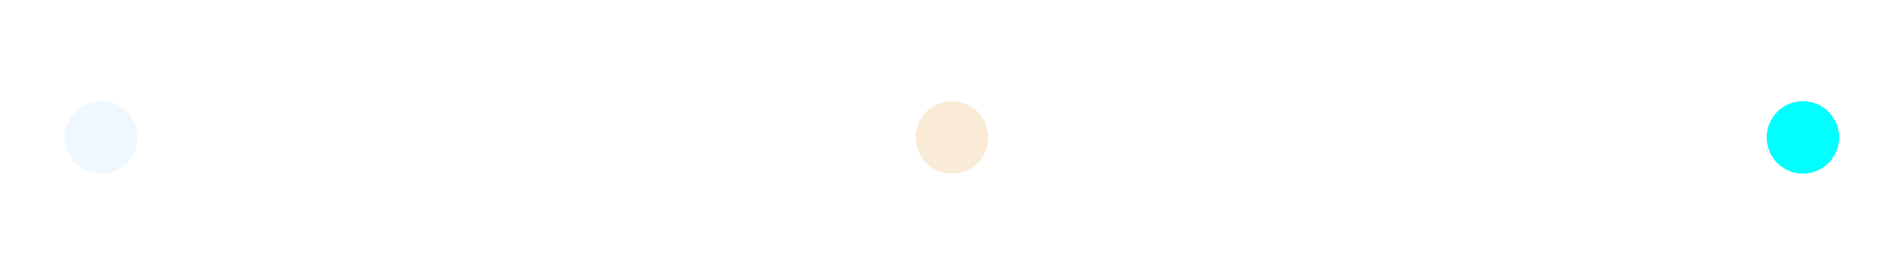

In [11]:
# we can overlay qualitative data onto the graph. Here i will overlay k-means clustering
num_clusters = 3
clust_model = KMeans(n_clusters=num_clusters, random_state=5).fit( pca_reduced_data)
qual_data = clust_model.labels_
qual_data
str_qual_data = qual_data.astype( str)
str_qual_data
analysis.plot_save_qual_graph(seed=seed, overlay=str_qual_data, file_out='3_clusters_overlay')


In [ ]:
# there is some funkiness with clusers intermingling, suggesting that our graph isn't the best. To resolve this we would want to run
# more graphs in the pCreode step. Otherwise it seems that the issues have been resolved due to minor version incompatibilities! 